In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv(r'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')


In [3]:
features = ['make', 'model', 'year', 'engine_hp','engine_cylinders', 'transmission_type', 'vehicle_style','highway_mpg', 'city_mpg', 'msrp']

In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [5]:
hw_df = df[features]

In [6]:
hw_df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [7]:
hw_df = hw_df.fillna(0)

In [8]:
average_price = hw_df['msrp'].mean()
hw_df['above_average'] = (hw_df['msrp'] >= average_price).astype(int)
hw_df = hw_df.drop('msrp', axis=1)

In [9]:
hw_df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,1


In [10]:
from sklearn.model_selection import train_test_split

X = hw_df.drop('above_average', axis=1)  
y = hw_df['above_average']  # Target variable

# Split the data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Display the sizes of the resulting sets
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_valid.shape[0])
print("Test set size:", X_test.shape[0])


Training set size: 7148
Validation set size: 2383
Test set size: 2383


In [11]:
from sklearn.feature_extraction import DictVectorizer


In [12]:
auc_results = pd.DataFrame(columns=['Variable', 'ROC AUC'])


In [13]:
from sklearn.metrics import roc_auc_score

variables = []
roc_aucs = []

for column in X_train.select_dtypes(include=['number']):
    # Calculate the ROC AUC score for the variable
    auc = roc_auc_score(y_train, X_train[column])
    
    # Check if the AUC is less than 0.5
    if auc < 0.5:
        # If AUC is less than 0.5, invert the variable and recalculate AUC
        inverted_auc = roc_auc_score(y_train, -X_train[column])
        
        # Add the variable with '-' in front and the inverted AUC to the lists
        variables.append('-' + column)
        roc_aucs.append(inverted_auc)
    else:
        # Add the variable and its AUC to the lists
        variables.append(column)
        roc_aucs.append(auc)

auc_results = pd.DataFrame({'Variable': variables, 'ROC AUC': roc_aucs})

print(auc_results)

           Variable   ROC AUC
0              year  0.694302
1         engine_hp  0.915900
2  engine_cylinders  0.768275
3      -highway_mpg  0.633369
4         -city_mpg  0.672327


## Answer1 = Engine HP

In [14]:
dv = DictVectorizer(sparse=False)

In [15]:
train_dict = X_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [18]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
val_dict = X_valid.to_dict(orient='records')
X_valid = dv.transform(val_dict)

y_pred = model.predict_proba(X_valid)[:, 1]
auc_valid = roc_auc_score(y_valid, y_pred)


In [20]:
np.round(auc_valid,3)

0.98

ANSWER2 = 0.979


In [21]:
y_pred

array([1.95035050e-03, 2.74249350e-02, 2.17101326e-05, ...,
       3.19060055e-01, 9.17129183e-04, 5.66197356e-01])

In [22]:
y_pred.min()

2.8560884525427343e-06

In [23]:
y_pred.max()

0.9999999998353333

In [24]:
actual_positive = (y_valid == 1)
actual_negative = (y_valid == 0)

In [25]:

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [26]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [27]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[1671,   66],
       [  87,  559]])

In [28]:
(confusion_matrix / confusion_matrix.sum()).round(2)


array([[0.7 , 0.03],
       [0.04, 0.23]])

In [29]:
p = tp / (tp + fp)
p

0.8944

In [30]:
r = tp / (tp + fn)
r

0.8653250773993808

In [31]:
tpr = tp / (tp + fn)
tpr

0.8653250773993808

In [32]:
fpr = fp / (fp + tn)
fpr

0.037996545768566495

In [33]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_valid == 1)
    actual_negative = (y_valid == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # Calculate precision and recall, handling the case when (tp + fp) is zero
    if tp + fp == 0:
        p = 0
    else:
        p = tp / (tp + fp)
    
    r = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, p, r))

In [34]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn','p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

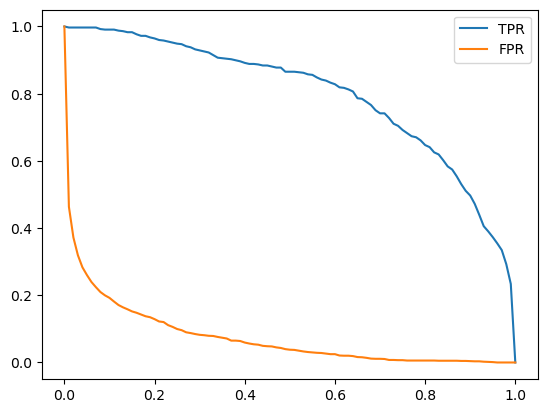

In [35]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [36]:
df_scores

,threshold,tp,fp,fn,tn,p,r,tpr,fpr
0,0.00,646,1737,0,0,0.271087,1.000000,1.000000,1.000000
1,0.01,644,805,2,932,0.444444,0.996904,0.996904,0.463443
2,0.02,644,646,2,1091,0.499225,0.996904,0.996904,0.371906
3,0.03,644,554,2,1183,0.537563,0.996904,0.996904,0.318941
4,0.04,644,492,2,1245,0.566901,0.996904,0.996904,0.283247
...,...,...,...,...,...,...,...,...,...
96,0.96,229,0,417,1737,1.000000,0.354489,0.354489,0.000000
97,0.97,216,0,430,1737,1.000000,0.334365,0.334365,0.000000
98,0.98,189,0,457,1737,1.000000,0.292570,0.292570,0.000000
99,0.99,151,0,495,1737,1.000000,0.233746,0.233746,0.000000


Text(0.5, 0, 'Treshold')

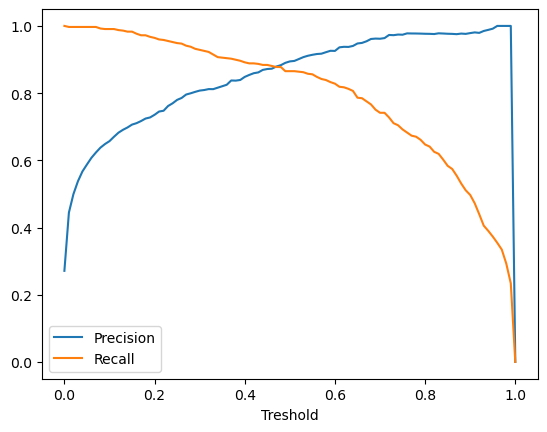

In [37]:
plt.plot(df_scores.threshold, df_scores['p'], label='Precision')
plt.plot(df_scores.threshold, df_scores['r'], label='Recall')
plt.legend()
plt.xlabel('Treshold')


In [38]:
intersection_threshold = thresholds[np.argwhere(np.diff(np.sign(np.array(df_scores['p']) - np.array(df_scores['r']))))[0][0]]


In [39]:
intersection_threshold

0.46

## Answer3 = 0.46

## Question 4 

In [40]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_valid == 1)
    actual_negative = (y_valid == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    # Calculate precision and recall, handling the case when (tp + fp) is zero
    if tp + fp == 0:
        p = 0
    else:
        p = tp / (tp + fp)
        f1 = 2* (p*r/(p+r))
    
    r = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, p, r, f1))

In [41]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn','p', 'r','f1']
df_scores = pd.DataFrame(scores, columns=columns)

In [42]:
df_scores['f1'].max()

0.8860309529962386

In [43]:
max_f1_rows = df_scores[df_scores['f1'] == df_scores['f1'].max()]

print(max_f1_rows)


    threshold   tp  fp  fn    tn         p         r        f1
54       0.54  554  54  92  1683  0.911184  0.857585  0.886031


## Answer 4 = 0.52~

## Question 5

In [44]:
hw_df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0
...,...,...,...,...,...,...,...,...,...,...
11909,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11910,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11911,acura,zdx,2012,300.0,6.0,automatic,4dr_hatchback,23,16,1
11912,acura,zdx,2013,300.0,6.0,automatic,4dr_hatchback,23,16,1


In [45]:
df_full_train, df_test = train_test_split(hw_df, test_size=0.2, random_state=1)




In [46]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [47]:
df_full_train

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
2711,mercedes-benz,clk-class,2007,382.0,8.0,automatic,coupe,22,15,1
333,nissan,370z,2016,332.0,6.0,manual,coupe,26,18,0
9377,gmc,sierra_1500,2017,285.0,6.0,automatic,extended_cab_pickup,24,18,0
939,porsche,911,2016,350.0,6.0,manual,convertible,26,19,1
5675,volkswagen,gti,2013,200.0,4.0,manual,4dr_hatchback,31,21,0
...,...,...,...,...,...,...,...,...,...,...
7813,audi,q5,2016,272.0,6.0,automatic,4dr_suv,26,18,1
10955,toyota,tundra,2015,381.0,8.0,automatic,crew_cab_pickup,17,13,1
905,saab,900,1997,150.0,4.0,manual,4dr_hatchback,26,18,0
5192,pontiac,g6,2009,164.0,4.0,automatic,coupe,33,22,0


In [48]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [49]:
from sklearn.model_selection import KFold


In [50]:
!pip install tqdm

from tqdm.auto import tqdm


In [51]:
n_splits = 5
C = 1

auc_scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=C)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

mean_auc = np.mean(auc_scores)
std_dev_auc = np.std(auc_scores)

print('Mean AUC: %.3f' % mean_auc)
print('Standard Deviation of AUC Scores: %.3f' % std_dev_auc)

0it [00:00, ?it/s]

Mean AUC: 1.000
Standard Deviation of AUC Scores: 0.000


## Answer : 0,003

In [52]:
n_splits = 5

for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.997 +- 0.001
C=0.1 1.000 +- 0.000
C=0.5 1.000 +- 0.000
C=10 1.000 +- 0.000


In [53]:
C_values = [0.01, 0.1, 0.5, 10]

mean_scores = {}
std_dev_scores = {}

n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for C in tqdm(C_values):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    mean_auc = np.mean(scores)
    std_dev_auc = np.std(scores)

    mean_scores[C] = mean_auc
    std_dev_scores[C] = std_dev_auc

best_C = max(mean_scores, key=mean_scores.get)

print("Mean AUC Scores:")
for C, mean_auc in mean_scores.items():
    print(f'C={C}: Mean AUC = {mean_auc:.3f} (Std Dev = {std_dev_scores[C]:.3f})')

print(f"The best C value is {best_C} with a mean AUC of {mean_scores[best_C]:.3f}")

  0%|          | 0/4 [00:00<?, ?it/s]

Mean AUC Scores:
C=0.01: Mean AUC = 0.997 (Std Dev = 0.001)
C=0.1: Mean AUC = 1.000 (Std Dev = 0.000)
C=0.5: Mean AUC = 1.000 (Std Dev = 0.000)
C=10: Mean AUC = 1.000 (Std Dev = 0.000)
The best C value is 0.5 with a mean AUC of 1.000


## Answer Last = 0.5